In [1]:
 pip	install	--upgrade	pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
 !pip	install	-q	pandas	numpy	scikit-learn	seaborn	matplotlib	gradio	joblib

In [3]:
 import	pandas	as	pd
 import	numpy	as	np
 from	sklearn.model_selection	import	train_test_split
 from	sklearn.preprocessing	import	LabelEncoder,	StandardScaler
 from	sklearn.svm	import	SVC
 from	sklearn.metrics	import	accuracy_score,	confusion_matrix
 import	seaborn	as	sns
 import	matplotlib.pyplot	as	plt
 import	gradio	as	gr
 import	joblib

In [6]:
 DATA_PATH	=	"Toddler Autism dataset July 2018.csv"
 df_raw	=	pd.read_csv(DATA_PATH)
 print("Loaded	dataset:",	DATA_PATH)
 print("Raw	shape:",	df_raw.shape)
 display(df_raw.head())

Loaded	dataset: Toddler Autism dataset July 2018.csv
Raw	shape: (1054, 19)


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [7]:
drop_cols = ['Case_No', 'Who completed the test']
df = df_raw.drop(columns=drop_cols, errors='ignore').copy()

In [11]:
# Ensure target column exists
target_col = None
for cand in ['Class/ASD Traits ', 'Class/ASD Traits', 'Class/ASD Traits.']:
    if cand in df.columns:
        target_col = cand
        break
if target_col is None:
    raise ValueError("Could not find target column 'Class/ASD Traits ' in dataset. Columns found:\n" + ", ".join(df.columns))

# Keep original (unencoded) values for UI choices
df_original = df.copy()


In [12]:
# We'll create LabelEncoders for all object-like columns (and remember numeric columns too)
encoders = {}
feature_columns = [c for c in df.columns if c != target_col]

In [13]:
# If any columns are numeric but represent categories (e.g., 0/1), we still handle them as numeric.
# Fit LabelEncoders on columns that are object or have few unique string values.
for col in feature_columns:
    if df[col].dtype == 'object' or df[col].nunique() <= 10:
        le = LabelEncoder()
        # convert to string to make sure encoder handles mixed types consistently
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
    else:
        # leave numeric columns as-is
        pass


In [14]:
# For target, make sure it's numeric encoded
if df[target_col].dtype == 'object':
    target_le = LabelEncoder()
    df[target_col] = target_le.fit_transform(df[target_col].astype(str))
else:
    target_le = None


In [15]:
# ---------- Train-test split, scaling, model ----------
X = df[feature_columns]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train_scaled, y_train)


SVC(probability=True)

In [16]:
# Evaluate quickly
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\nModel trained. Test accuracy: {acc*100:.2f}%")




Model trained. Test accuracy: 99.53%


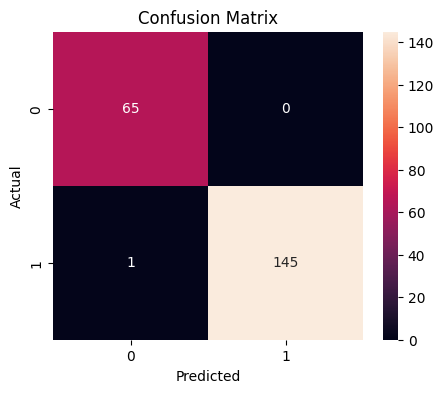

In [17]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [18]:
# Persist model/scaler/encoders so UI code can re-load if needed
joblib.dump(svm_model, "svm_model_autism.pkl")
joblib.dump(scaler, "scaler_autism.pkl")
joblib.dump(encoders, "encoders_autism.pkl")
if target_le is not None:
    joblib.dump(target_le, "target_le_autism.pkl")


In [19]:
# ---------- Build user-friendly labels for certain columns (override if we know mapping) ----------
# If your CSV uses A1..A10 or similar column names we can map them to real questions:
# Provide a mapping from possible column names to the "real" question text. Update if needed.
question_overrides = {
    # keys should match column names in your dataset if they exist
    "A1_Score": "Does the child look at you when you call their name?",
    "A2_Score": "Is it easy to get eye contact with the child?",
    "A3_Score": "Does the child point to indicate interest (e.g., pointing to a toy)?",
    "A4_Score": "Does the child play pretend or make-believe games?",
    "A5_Score": "Does the child enjoy peek-a-boo or hide and seek?",
    "A6_Score": "Does the child copy or imitate actions (like clapping)?",
    "A7_Score": "Does the child respond when you smile at them?",
    "A8_Score": "Does the child show interest in other children?",
    "A9_Score": "Does the child smile back when you smile at them?",
    "A10_Score": "Does the child follow your gaze when you point at something?",
    # common dataset alternative names - add as needed:
    "A1": "Does the child look at you when you call their name?",
    "A2": "Is it easy to get eye contact with the child?",
    "A3": "Does the child point to indicate interest (e.g., pointing to a toy)?",
    "A4": "Does the child play pretend or make-believe games?",
    "A5": "Does the child enjoy peek-a-boo or hide and seek?",
    "A6": "Does the child copy or imitate actions (like clapping)?",
    "A7": "Does the child respond when you smile at them?",
    "A8": "Does the child show interest in other children?",
    "A9": "Does the child smile back when you smile at them?",
    "A10": "Does the child follow your gaze when you point at something?"
}


In [20]:
# ---------- Build Gradio inputs dynamically and the prediction function ----------
# For each feature column, create a user-friendly label and appropriate Gradio input component.
gr_inputs = []
ui_feature_order = []  # keep the exact order we will assemble the input vector in

for col in feature_columns:
    ui_feature_order.append(col)
    # if the column had an encoder, present its original choices (sorted) as a Dropdown / Radio
    if col in encoders:
        le = encoders[col]
        # get classes in original string form
        classes = list(le.classes_)
        # if there are exactly two options and they look like '0'/'1' or 'Yes'/'No', use Radio
        if len(classes) == 2:
            # Use Radio to be clear
            # Prefer showing the original readable labels
            choices = [str(c) for c in classes]
            label = question_overrides.get(col, col)
            gr_inputs.append(gr.Radio(choices, label=label))
        else:
            # Use Dropdown for multi-class
            choices = [str(c) for c in classes]
            label = question_overrides.get(col, col)
            gr_inputs.append(gr.Dropdown(choices, label=label))
    else:
        # numeric column: use Number input
        label = question_overrides.get(col, col)
        gr_inputs.append(gr.Number(label=label))



In [21]:
def make_predict_fn(model, scaler, encoders, feature_names, target_le=None):
    def predict_fn(*gr_inputs_values):
        # gr_inputs_values come in same order as feature_names
        if len(gr_inputs_values) != len(feature_names):
            return "Input length mismatch. Expected {} values, got {}.".format(
                len(feature_names), len(gr_inputs_values)
            )

        row = []
        for col, val in zip(feature_names, gr_inputs_values):
            if col in encoders:
                le = encoders[col]
                # The UI returns strings from choices; convert to encoder numeric representation
                try:
                    encoded = le.transform([str(val)])[0]
                except ValueError:
                    # If direct transform fails, try to find the matching class manually
                    classes = list(le.classes_)
                    match_index = None

                    # Attempt exact match (case-insensitive)
                    for i, cls in enumerate(classes):
                        if str(cls).lower() == str(val).lower():
                            match_index = i
                            break

                    # Fallback: numeric match
                    if match_index is None:
                        for i, cls in enumerate(classes):
                            try:
                                if float(cls) == float(val):
                                    match_index = i
                                    break
                            except:
                                pass

                    if match_index is None:
                        return f"Input value '{val}' is not valid for field '{col}'. Valid options: {classes}"

                    encoded = match_index

                row.append(encoded)
            else:
                try:
                    row.append(float(val))
                except:
                    return f"Please enter a numeric value for '{col}'."

        X_in = np.array(row).reshape(1, -1)

        try:
            X_scaled = scaler.transform(X_in)
        except Exception as e:
            return f"Error scaling input: {e}"

        try:
            pred = model.predict(X_scaled)[0]
            prob = model.predict_proba(X_scaled)[0].max()
        except Exception as e:
            return f"Model prediction error: {e}"

        # Convert prediction to readable label if target_le exists
        if target_le is not None:
            pred_label = target_le.inverse_transform([int(pred)])[0]
            return f"Prediction: {pred_label}\nConfidence: {prob*100:.2f}%"
        else:
            return f"Prediction code: {int(pred)}\nConfidence: {prob*100:.2f}%"

    return predict_fn


# Example usage:
predict_fn = make_predict_fn(svm_model, scaler, encoders, ui_feature_order, target_le=target_le)


In [25]:
# ---------- Launch Gradio ----------
iface = gr.Interface(
    fn=predict_fn,
    inputs=gr_inputs,
    outputs=gr.Textbox(label="Prediction Result"),
    title="Autism Prediction (SVM) — Dataset-driven UI",
    description="This UI was generated automatically to match the uploaded dataset's columns and encodings.",
    allow_flagging="never"
)

print("\nLaunching Gradio interface (inline). If you are in Colab, use the displayed link.")
iface.launch(inline=True, share=False)


C:\Users\Ganesh Lakshman\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(



Launching Gradio interface (inline). If you are in Colab, use the displayed link.
* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
